In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


2025-02-28 12:16:30.028748: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# # Download Stock Data
# start = '2012-01-01'
# end = '2022-12-21'
# stock = 'GOOG'
# data = yf.download(stock, start, end)
# data.reset_index(inplace=True)
# data.dropna(inplace=True)

In [3]:
data=pd.read_csv("NICA_2000-01-01_2021-12-31.csv")

In [4]:
data

,S.N.,Date,Total Transactions,Total Traded Shares,Total Traded Amount,Max. Price,Min. Price,Close
0,1,2021-12-29,517,77201.0,56817535.0,744.0,725.0,740.0
1,2,2021-12-28,269,43607.0,32180061.8,747.0,730.0,738.0
2,3,2021-12-27,488,65018.0,49019615.4,774.0,744.0,744.0
3,4,2021-12-26,450,70760.0,54269788.7,775.0,760.0,769.9
4,5,2021-12-23,343,53583.0,40522914.0,767.0,749.0,760.0
...,...,...,...,...,...,...,...,...
2409,2410,2010-04-20,16,2345.0,1173081.0,522.0,492.0,493.0
2410,2411,2010-04-19,5,334.0,169336.0,510.0,502.0,502.0
2411,2412,2010-04-15,3,629.0,334950.0,535.0,530.0,530.0
2412,2413,2010-04-15,3,629.0,334950.0,535.0,530.0,530.0


In [5]:

# Train-Test Split
data_train = data['Close'][:int(len(data)*0.80)]
data_test = data['Close'][int(len(data)*0.80):]


In [6]:
print(f"Shape of train={data_train.shape}\nShape of data_test={data_test.shape}")

Shape of train=(1931,)
Shape of data_test=(483,)


In [7]:
# Scaling Data
scaler = MinMaxScaler(feature_range=(0,1))
data_train_scaled = scaler.fit_transform(np.array(data_train).reshape(-1,1))
data_test_scaled = scaler.transform(np.array(data_test).reshape(-1,1))

In [8]:
print(data_train_scaled)

[[0.68965517]
 [0.68779124]
 [0.69338304]
 ...
 [0.42124884]
 [0.4305685 ]
 [0.4277726 ]]


In [9]:
# Create Training Sequences
x_train, y_train = [], []
for i in range(500, len(data_train_scaled)):
    x_train.append(data_train_scaled[i-500:i])
    y_train.append(data_train_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
import os
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout

model_path = 'stock_model_improved.keras'

if os.path.exists(model_path):
    model = load_model(model_path)
    print("Loaded pre-trained model. Fine-tuning...")
    # model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
else:
    # Build LSTM Model with more hidden layers
    model = Sequential([
        LSTM(64, activation='tanh', return_sequences=True, input_shape=(x_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(128, activation='tanh', return_sequences=True),
        Dropout(0.3),
        LSTM(64, activation='tanh', return_sequences=True),
        Dropout(0.3),
        LSTM(32, activation='tanh', return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
    model.save(model_path)
    print("Model trained and saved.")


Epoch 1/50
36/36 [==============================] - 31s 748ms/step - loss: 0.0311 - val_loss: 0.0112
Epoch 2/50
36/36 [==============================] - 25s 685ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 3/50
36/36 [==============================] - 25s 687ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 4/50
36/36 [==============================] - 25s 686ms/step - loss: 0.0057 - val_loss: 0.0068
Epoch 5/50
36/36 [==============================] - 25s 690ms/step - loss: 0.0063 - val_loss: 0.0059
Epoch 6/50
36/36 [==============================] - 25s 697ms/step - loss: 0.0054 - val_loss: 0.0108
Epoch 7/50
36/36 [==============================] - 25s 695ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 8/50
36/36 [==============================] - 26s 722ms/step - loss: 0.0056 - val_loss: 0.0073
Epoch 9/50
36/36 [==============================] - 25s 696ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 10/50
36/36 [==============================] - 27s 744ms/step - loss: 0.0052 - val_lo

In [11]:
# # Access the loss and val_loss after model training
# # training_loss = model.history.history['loss']
# validation_loss = model.history.history['val_loss']


In [12]:

# Prepare Test Data
past_100_days = data_train.tail(100).values.reshape(-1,1)
past_100_days_scaled = scaler.transform(past_100_days)
data_test_scaled = np.concatenate((past_100_days_scaled, data_test_scaled))

x_test, y_test = [], []
for i in range(500, len(data_test_scaled)):
    x_test.append(data_test_scaled[i-500:i])
    y_test.append(data_test_scaled[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)


In [13]:
# ## Preparing the test data
# past_all_data=data
# x_test, y_test-

In [14]:
print(f"Shape of test={x_test.shape}\nShape of data_test={y_test.shape}")

Shape of test=(83, 500, 1)
Shape of data_test=(83,)


In [15]:
# Make Predictions
y_pred_scaled = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

3/3 [==============================] - 2s 192ms/step


In [16]:
# Performance Metrics
print("MAE:", mean_absolute_error(y_test_actual, y_pred))
print("R² Score:", r2_score(y_test_actual, y_pred))

MAE: 24.38689854633377
R² Score: 0.7185774323414447


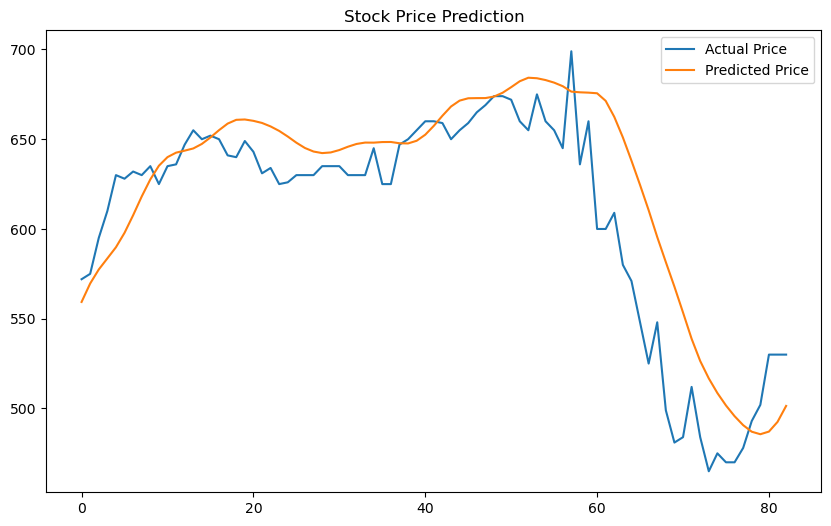

In [17]:

# Visualization
plt.figure(figsize=(10,6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(y_pred, label='Predicted Price')
plt.legend()
plt.title('Stock Price Prediction')
plt.savefig("nica_acutal_predicted.png")
plt.show()


In [18]:
# model.save('Improved_condaVenvfinal.keras')